In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/Train')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
S_PREFIX = 'pad-instead'

In [8]:
test = np.zeros((96, 200, 3))

In [9]:
np.pad(test, [(0,0), (0,24), (0,0)], mode='constant').shape

(96, 224, 3)

### Create dataloader

In [10]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img[:,:,2]==VEHICLES] = 1
    # yv = y_img[:,:,2]==VEHICLES
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:,:] = 0

    y_new[y_img[:,:,2]==ROADS] = 2
    y_new[y_img[:,:,2]==ROAD_LINES] = 2
#     print(np.mean(y_new))
    return y_new

In [11]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
#             return im
            return convert_y(im)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [12]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 2
#     def get(self, tfm, x, y):
#         x,y = super().get(tfm, x, y)
#         print(y.shape)
#         return x,y

In [13]:
def crop_bg(x, y):
#     print(x.shape)
    # Original
    h,w,c = x.shape
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    x,y = x[top:bot,:,:],y[top:bot,:,:]
    pad_right=32-w%32
    if pad_right:
        x = np.pad(x, [(0,0),(0,pad_right),(0,0)], 'constant')
        y = np.pad(y, [(0,0),(0,pad_right),(0,0)], 'constant')
#     print(y.shape)
    return x,y
    

In [14]:

class RC(CoordTransform):
    """ A class that represents a Random Crop transformation.

    This transforms (optionally) transforms x,y at with the same parameters.
    Arguments
    ---------
        targ: int
            target size of the crop.
        tfm_y: TfmType
            type of y transformation.
    """
    def __init__(self, targ_sz, tfm_y=TfmType.NO, sz_y=None):
        super().__init__(tfm_y)
        self.targ_sz,self.sz_y = targ_sz,sz_y

    def set_state(self):
        self.store.rand_r = random.uniform(0, 1)
        self.store.rand_c = random.uniform(0, 1)

    def do_transform(self, x, is_y):
#         print('RC pre:', x.shape)
        r,c,*_ = x.shape
        sz = self.sz_y if is_y else self.targ_sz
        start_r = np.floor(self.store.rand_r*(r-sz)).astype(int)
        start_c = np.floor(self.store.rand_c*(c-sz)).astype(int)
        res = crop(x, start_r, start_c, sz)
        return res

In [15]:
x_names_val = np.array(glob(str(PATH/'AnswersRGB'/'*.png')))
y_names_val = np.array(glob(str(PATH/'AnswersSeg'/'*.png')))

In [16]:
def get_data(f_ext, bs, size):
    x_names = np.array(glob(str(PATH/f'CameraRGB{f_ext}'/'*.png')))
    y_names = np.array(glob(str(PATH/f'CameraSeg{f_ext}'/'*.png')))
    x_names_val = np.array(glob(str(PATH/f'AnswersRGB{f_ext}'/'*.png')))
    y_names_val = np.array(glob(str(PATH/f'AnswersSeg{f_ext}'/'*.png')))
    val_idxs = list(range(100))
    val_x,val_y = x_names_val, y_names_val
    trn_x,trn_y = x_names, y_names
#     ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    aug_tfms = [
        crop_bg,
#         RandomScale(sz, 1.1, tfm_y=TfmType.CLASS, sz_y=sz),
#         RC(sz, tfm_y=TfmType.CLASS, sz_y=sz),
        RandomRotate(4, tfm_y=TfmType.CLASS),
        RandomFlip(tfm_y=TfmType.CLASS),
        RandomLighting(0.05, 0.1, tfm_y=TfmType.CLASS)
    ]
    tfms = tfms_from_model(resnet34, size, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms, scale=[])
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
    del md.trn_ds.transform.tfms[-3]
    del md.val_ds.transform.tfms[-3]
    md.val_ds.transform.tfms.insert(0, crop_bg)
    denorm = md.trn_ds.denorm
    return md

In [17]:
sz = 96
bs = 2
md = get_data('-150', bs, sz)

In [18]:
md.trn_ds.transform

[<function crop_bg at 0x7fa9daad87b8>, <fastai.transforms.RandomRotate object at 0x7faa604e9128>, <fastai.transforms.RandomFlip object at 0x7faa604d90f0>, <fastai.transforms.RandomLighting object at 0x7fa9daa75390>, <fastai.transforms.Normalize object at 0x7fa9daa75630>, <fastai.transforms.ChannelOrder object at 0x7fa9daa754e0>]

In [19]:
md.val_ds.transform

[<function crop_bg at 0x7fa9daad87b8>, <fastai.transforms.Normalize object at 0x7fa9daa75630>, <fastai.transforms.ChannelOrder object at 0x7fa9daa75c88>]

In [20]:
it = iter(md.trn_dl)

In [21]:
y_img = cv2.imread(y_names_val[0])

In [22]:
x,y = next(it)

In [23]:
x.shape, y.shape

(torch.Size([2, 3, 96, 224]), torch.Size([2, 96, 224]))

In [24]:
np.mean(y[0])

0.5900297619047619

In [34]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [35]:
f = resnet34
cut,lr_cut = model_meta[f]

In [36]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

## U-net (ish)

In [37]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [38]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [39]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [40]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [41]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.CrossEntropyLoss()
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[new_acc, dice_mult]
    return learn

In [153]:
ext = '-150'
sz = 96
bs = 64

In [154]:
md = get_data(ext, bs, sz)

In [155]:
learn = get_learner(md)

In [156]:
x,y = next(iter(md.trn_dl))

In [157]:
learn.freeze_to(1)

### Loading from train6 model

In [158]:
learn.load('600urn-multi')

epoch      trn_loss   val_loss   new_acc    dice_mult     
    0      1.494227   1.1641463483756992e+24 0.015825   0.740461  



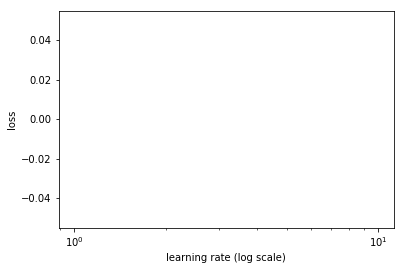

In [159]:
learn.lr_find()
learn.sched.plot()

In [160]:
lr=4e-2
# lr=4e-3
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [161]:
learn.fit(lr,1,wds=wd,cycle_len=15,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc    dice_mult      
    0      0.224271   0.153522   0.941662   1.868775  
    1      0.122321   0.052065   0.982949   1.936908       
    2      0.084174   0.045092   0.986052   1.947765        
    3      0.064179   0.04356    0.986571   1.94979         
    4      0.052146   0.041168   0.987511   1.949031        
    5      0.044187   0.041847   0.987929   1.950961        
    6      0.038678   0.042878   0.987819   1.94894         
    7      0.034475   0.043285   0.987894   1.949247        
    8      0.031514   0.039863   0.988622   1.952716        
    9      0.029085   0.042782   0.987874   1.95189         
    10     0.027084   0.041577   0.98846    1.951098        
    11     0.025655   0.042504   0.988472   1.950923        
    12     0.024488   0.041141   0.988678   1.952139        
    13     0.023559   0.04301    0.988529   1.951279        
    14     0.022828   0.041148   0.989047   1.952421        



[array([0.04115]), 0.9890469908714294, 1.9524205780736497]

In [162]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [163]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [164]:
learn.unfreeze()
learn.bn_freeze(True)

In [165]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.020253   0.043291   0.988746   1.952957  
    1      0.020341   0.043042   0.988925   1.952308        
    2      0.020143   0.042269   0.989157   1.952204        
    3      0.019638   0.042493   0.989056   1.952672        
    4      0.019429   0.041601   0.989157   1.952328        
    5      0.019139   0.042018   0.989407   1.953402        
    6      0.018901   0.042769   0.989414   1.952596        
    7      0.018706   0.041417   0.989562   1.953704        
    8      0.018552   0.042131   0.989436   1.953099        
    9      0.018384   0.042538   0.989396   1.952905        



[array([0.04254]), 0.989395797252655, 1.952905321114439]

In [166]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.018225   0.045735   0.988813   1.950956  
    1      0.018342   0.041737   0.98954    1.953813        
    2      0.018234   0.042306   0.98961    1.953439        
    3      0.018117   0.042285   0.989441   1.954026        
    4      0.017995   0.043677   0.989098   1.952149        
    5      0.017835   0.042931   0.989283   1.953015        
    6      0.017619   0.043119   0.989504   1.952866        
    7      0.017449   0.043595   0.989275   1.952099        
    8      0.017312   0.042753   0.989512   1.953528        
    9      0.017137   0.042149   0.989743   1.953881        



[array([0.04215]), 0.9897429943084717, 1.9538808463471562]

In [167]:
learn.save(f'128urn-{S_PREFIX}-0')

In [168]:
learn.load(f'128urn-{S_PREFIX}-0')

In [169]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [170]:
py = np.argmax(py,1)

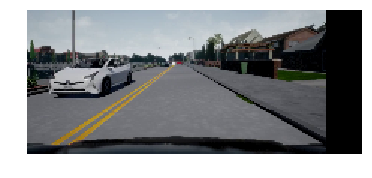

In [171]:
show_img(md.trn_ds.denorm(x)[0])

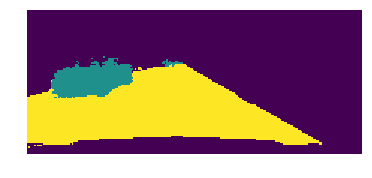

In [172]:
show_img(py[0]);

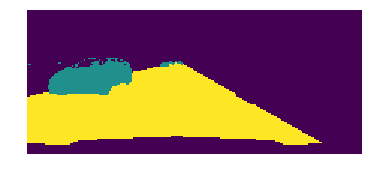

In [173]:
show_img(y[0]);

## 256x256

In [177]:
sz=192
bs=64

In [178]:
md = get_data('-300', bs, sz)

In [179]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [180]:
learn = get_learner(md)

In [181]:
learn.freeze_to(1)

In [182]:
learn.load(f'128urn-{S_PREFIX}-0')

In [183]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.033206   0.046414   0.989086   1.955005  
    1      0.025984   0.046055   0.989739   1.954054        
    2      0.022555   0.046088   0.989255   1.954731        
    3      0.02034    0.043201   0.989693   1.955081        
    4      0.01872    0.047233   0.989306   1.954952        
    5      0.017436   0.047093   0.989839   1.955472        
    6      0.01666    0.046889   0.989917   1.954536        
    7      0.015895   0.046468   0.990166   1.955407        
    8      0.01526    0.046639   0.990244   1.956039        
    9      0.014808   0.046702   0.990334   1.956162        



[array([0.0467]), 0.9903340935707092, 1.956162140837662]

In [184]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [185]:
learn.unfreeze()
learn.bn_freeze(True)

In [186]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [187]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.013334   0.048705   0.990363   1.955953  
    1      0.013245   0.048208   0.990268   1.955781        
    2      0.013104   0.048212   0.990414   1.95584         
    3      0.012974   0.049177   0.990347   1.955989       
    4      0.012836   0.048346   0.990348   1.956138        
    5      0.012744   0.048359   0.990486   1.956541        
    6      0.012647   0.048673   0.990427   1.956064        
    7      0.012557   0.048955   0.990443   1.95627         



[array([0.04896]), 0.9904430508613586, 1.9562699530794334]

In [188]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.0124     0.049023   0.990505   1.95638   
    1      0.012449   0.048888   0.990366   1.956294        
    2      0.012397   0.049163   0.990342   1.956236        
    3      0.012319   0.049209   0.990498   1.956355        
    4      0.012204   0.049019   0.99049    1.956135        
    5      0.01214    0.049444   0.990519   1.956199        
    6      0.012088   0.049104   0.990636   1.956619        
    7      0.012025   0.04951    0.990579   1.956527        



[array([0.04951]), 0.9905794858932495, 1.95652732899056]

In [189]:
learn.save(f'256urn-{S_PREFIX}')

In [190]:
learn.load(f'256urn-{S_PREFIX}')

In [191]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [192]:
py = np.argmax(py,1)

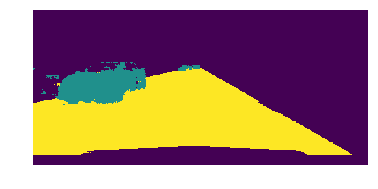

In [193]:
show_img(py[0]);

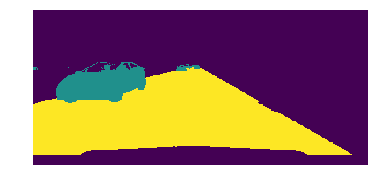

In [194]:
show_img(y[0]);

In [103]:
m.close()

NameError: name 'm' is not defined

## 512x512

In [42]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=288
bs=16

In [43]:
md = get_data('', bs, sz)

In [44]:
learn = get_learner(md)

In [199]:
learn.load(f'256urn-{S_PREFIX}')

In [200]:
learn.freeze_to(1)

In [48]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [202]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.020514   0.056057   0.988276   1.951702  
    1      0.015895   0.057347   0.986933   1.952662        
    2      0.013041   0.048664   0.990254   1.955296        
    3      0.01124    0.049098   0.990641   1.955585        



[array([0.0491]), 0.9906413952509562, 1.955585291461729]

In [203]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [49]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [50]:
learn.unfreeze()
learn.bn_freeze(True)

In [51]:
lrs = np.array([lr/200,lr/30,lr])

In [52]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult        
    0      0.009354   0.053346   0.990416   1.954519  
    1      0.009137   0.052886   0.990833   1.955717         
    2      0.00879    0.053885   0.990821   1.955632         
    3      0.008723   0.053668   0.990938   1.955941         



[array([0.05367]), 0.990937598546346, 1.9559406728582394]

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult        
    0      0.008684   0.054164   0.990891   1.955948  
    1      0.00865    0.054376   0.990785   1.955627         
    2      0.008511   0.054047   0.990926   1.956038         
 10%|▉         | 6/63 [00:13<02:09,  2.28s/it, loss=0.0085] 

In [ ]:
learn.sched.plot_loss()

In [53]:
learn.save(f'600urn-{S_PREFIX}')

In [427]:
learn.load(f'600urn-{S_PREFIX}')

In [428]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

TypeError: Invalid dimensions for image data

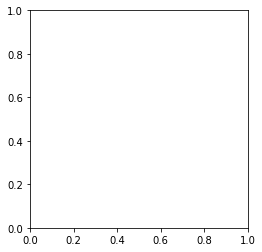

In [429]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

## Save results

In [430]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [33]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

NameError: name 'get_base' is not defined

In [436]:
# model_summary(m, [3,608,800])

In [437]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [434]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()